# The Growing Neural Gas and Merge Growing Neural Gas Algorithms

[*Growing Neural Gas (NGN)*](https://papers.nips.cc/paper/893-a-growing-neural-gas-network-learns-topologies.pdf) is a [topology preserving (see this blog for a demonstration)](http://neupy.com/2018/03/26/making_art_with_growing_neural_gas.html) or [this explaination](http://neupy.com/2018/03/26/making_art_with_growing_neural_gas.html#id1)) extension to the [*Neural gas (NG)*]() approach is usefull for learning when an underlying topology is not known (as in the case of the [*Self-organizing maps (SOM)*]() algorithm). When it comes to time series data (such as trajectories), an extension to the neural gas algorithm has been approached (*Merge Neural Gas (MNG)*) and a combination with the GNG leads to the [*Merge growing neural gas (MNGN)*](https://ias.in.tum.de/_media/spezial/bib/andreakis09wsom.pdf) approach. It adds a context memory to the neurons of the NGN and is useful for *recognising* temporal sequences and with a single weighting parameter, can be reduced to a regular NGN for which an implementation [is available](https://github.com/itdxer/neupy/blob/master/notebooks/growing-neural-gas/Making%20Art%20with%20Growing%20Neural%20Gas.ipynb).

This notebook allows experimenting with the (M)NGN algorithms on our own vanilla [numpy](https://numpy.org/) implementation (which can be executed on the GPU with [Cupy](https://cupy.chainer.org/)). The package uses modern python tools such as [poetry](https://python-poetry.org/), [attrs](https://www.attrs.org/en/stable/) (a focus has been laid on those two for this release), and sphinx and mypy/pylint/black for documentation and coding standards.

At first, let us import the necessary modules and set up loggin (aka. boilerplate code) 

In [2]:
from mgng import MergeGNG, lemniscate, get_dymmy_2D_data, repr_ndarray
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interactive, Layout

import numpy as np

import logging

logging.basicConfig(level=logging.ERROR,
                    format='%(name)s {%(filename)s:%(funcName)s:%(lineno)d} %(levelname)s - %(message)s',
#                     format='%(name)s [%(asctime)s] {%(filename)s:%(funcName)s:%(lineno)d} %(levelname)s - %(message)s',
#                     format='{%(filename)s:%(funcName)s:%(lineno)d} %(levelname)s - %(message)s',
                    datefmt='%m-%d %H:%M')

logger = logging.getLogger("jupyter")

logger.debug("test")

%matplotlib inline 


In [4]:
def show_topology(mgng: MergeGNG):
    for n, row in enumerate(mgng._connections):
            ind = np.nonzero(row)
            # print(ind)
            for i in ind[0]:
                plt.plot([mgng._weights[i,0], mgng._weights[n,0]], [mgng._weights[i, 1],mgng._weights[n,1]], '-y')
            
        

## Interactive playground

Use the following cell to interactively test on a data set (parameterized and rotated [Bernoulli lemniscate](https://en.wikipedia.org/wiki/Lemniscate_of_Bernoulli)):

interactive(children=(Dropdown(description='type_', options=('None', 'MGNG', 'GNG'), value='None'), Dropdown(d…

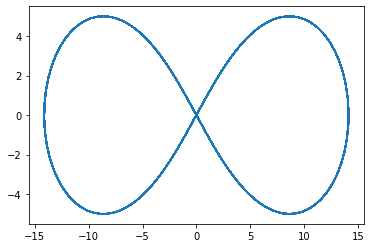

In [6]:
mgng = None

logging.getLogger('neurovision.mgng.mgng').setLevel(logging.WARNING)

def learn(type_, data, noise, target, repeats,samples,
      n_neurons, connection_decay,
      temporal_influence,
      memory_weight,
      life_span,
      learn_rate,learn_rate_neighbors,
      decrease_activity,
      delta, max_activity, epochs, creation_frequency):
    
    std = 0.0 if noise == 'Clean' else 1.0
    print(std)
    
    if data=='Single':
        X =  np.hstack(
            [lemniscate(0, x, samples) for x in np.random.randn(repeats)*std + 10]
        )
    else:
        X = get_dymmy_2D_data(repeats, samples, std)

    global mgng
    
    if type_ == 'MGNG':
        mgng = MergeGNG(
            n_neurons=n_neurons,
            n_dim=2,
            connection_decay=connection_decay,
            temporal_influence=temporal_influence,
            memory_weight=memory_weight,
            life_span=life_span,
            learn_rate=learn_rate,
            learn_rate_neighbors=learn_rate_neighbors,
            decrease_activity=decrease_activity,
            delta=delta,
            max_activity=max_activity,
            debug=False,
            creation_frequency=creation_frequency
            
        )

        mgng.learn(X.T,1)
        Y,Z = mgng.get_active_weights()
        plt.plot(Y.T[0, :], Y.T[1, :], '*g')
        plt.plot(Z.T[0, :], Z.T[1, :], '*r')
        
        for x,y in zip(mgng._weights, mgng._context):
            plt.plot([x[0],y[0]],[x[1],y[1]],'-k')
        show_topology(mgng)
        
    if target=='Show':
        plt.plot(X[0, :], X[1, :])
    display("Learned network stored to variable `mgng`")
    


interactive_plot = interactive(
    learn, 
    type_=['None','MGNG','GNG'],
    data = ['Single','Double'],
    noise = ['Clean', 'Noisy'],
    target = ['Show','Hide'],
    repeats=(1,50),
    samples=(10,250,10),
    n_neurons=(20,1000),
    connection_decay=(0.0,1.0),
    temporal_influence=(0.0,1.0),
    memory_weight=(0.0,1.0),
    life_span=(0,50),
    learn_rate=(0.0,1.0),
    learn_rate_neighbors=(0.0,0.8),
    decrease_activity=(0.0,1.0,0.01),
    delta=(0.0,1.0),
    max_activity=(1.0,3.0),
    epochs=(1,10),
    creation_frequency=(1,10)
)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
display(interactive_plot)



# Step-wise experimenting for parameter tuning

In the following cell, the parameter of the experiment/data is hard coded but the parameters of the algorithm can be modified interactively. The algorithm can proceed step wise and the step-size (`batch`) can be set independently.

In [14]:
from ipywidgets import widgets, interact_manual

logging.getLogger('neurovision.mgng.mgng').setLevel('WARNING')
logging.getLogger('neurovision.mgng.mgng').setLevel('INFO')
# logging.getLogger('neurovision.mgng.mgng').setLevel('DEBUG')


std = 0
repeats = 1
samples = 100
n_neurons = 100

mgng = MergeGNG(
    n_neurons=n_neurons,
    n_dim=2,
    temporal_influence=.0001,
    learn_rate=.5,
    life_span=10
)



if True:
    X =  np.hstack(
        [lemniscate(0, 1.0, samples) for x in np.random.randn(repeats)*std + 10]
    ).T
else:
    X = get_dymmy_2D_data(repeats, samples, std).T

iterator = 0
    
def steps(show_context,
          show_updates,
          show_inactives,
          activity_threshold,
          show_neighbors,
          connection_decay,
          temporal_influence,
          memory_weight,
          life_span,
          learn_rate,
          learn_rate_neighbors,
          decrease_activity,
          delta, batch):
    
    global iterator, mgng
    
    mgng.connection_decay = connection_decay
    mgng.temporal_influence = temporal_influence
    mgng.memory_weight = memory_weight
    mgng.life_span = life_span
    mgng.learn_rate = learn_rate
    mgng.decrease_activity = decrease_activity
    mgng.delta = delta
    mgng.learn_rate_neighbors = learn_rate_neighbors
    
    old_weights = mgng._weights.copy()
    old_context = mgng._context.copy()
    old_global = mgng._global_context.copy()
    
    for i in range(iterator,iterator+batch):
        if i < samples:
            first, second = mgng.adapt(X[i,:])
            mgng._counter *= mgng.decrease_activity
            if i % 5 == 4:  # Make this a factor depending on the activity of neurons
                print("grow")
                mgng.grow()
    
    
    print(old_global, mgng._global_context,mgng._global_context.shape)
    plt.plot([mgng._global_context[0], old_global[0]], [mgng._global_context[1],old_global[1]], '--k')
    plt.plot([mgng._global_context[0]], [mgng._global_context[1]], 'hk')
    
    for i in np.nonzero(mgng._counter > activity_threshold):
        if show_context=="on":
            plt.plot([mgng._weights[i,0], mgng._context[i,0]], [mgng._weights[i, 1],mgng._context[i,1]], '-g')
        else:
            plt.plot([mgng._weights[i,0]], [mgng._weights[i, 1]], '-og')
            
        if show_updates=="on":
            if show_context=="on":
                plt.plot([old_context[i,0], mgng._context[i,0]], [old_context[i, 1],mgng._context[i,1]], ':sg')
                plt.plot([old_context[i,0], old_weights[i,0]], [old_context[i, 1],old_weights[i,1]], '--g')
            plt.plot([mgng._weights[i,0], old_weights[i,0]], [mgng._weights[i, 1],old_weights[i,1]], ':og')
        
    if show_inactives=="on":
        for i in np.nonzero(mgng._counter <= activity_threshold):
            if show_context=="on":
                plt.plot([mgng._weights[i,0], mgng._context[i,0]], [mgng._weights[i, 1],mgng._context[i,1]], '-r')
            else:
                plt.plot([mgng._weights[i,0]], [mgng._weights[i, 1]], '-og')
            if show_updates=="on":
                if show_context=="on":
                

                    plt.plot([old_context[i,0], mgng._context[i,0]], [old_context[i, 1],mgng._context[i,1]], ':sr')
                    plt.plot([old_context[i,0], old_weights[i,0]], [old_context[i, 1],old_weights[i,1]], '--r')
                plt.plot([mgng._weights[i,0], old_weights[i,0]], [mgng._weights[i, 1],old_weights[i,1]], ':or')
                
                
    if show_neighbors=="on":
        for n, row in enumerate(mgng._connections):
            ind = np.nonzero(row)
            # print(ind)
            for i in ind[0]:
                plt.plot([mgng._weights[i,0], mgng._weights[n,0]], [mgng._weights[i, 1],mgng._weights[n,1]], '-y')
            
        
        

    plt.plot(mgng._weights[first,0], mgng._weights[first, 1], 'om')
    plt.plot(mgng._weights[second,0], mgng._weights[second, 1], 'oc')
    
    
    plt.plot(X.T[0,:iterator+1], X.T[1, :iterator+1], '-b')
    plt.plot(X.T[0,iterator], X.T[1, iterator], 'ob')
    
    iterator = batch + iterator if batch+iterator < samples else 0
    print(iterator)
    plt.rcParams["figure.figsize"] = (20,20)
    
    
    

interactive_plot = interact_manual(
    steps, 
    show_context = ["on", "off"],
    show_updates = ["on", "off"],
    show_inactives = ["on", "off"],
    activity_threshold = widgets.FloatSlider(min=0,max=1.0,step=0.1,value=0.1),
    show_neighbors = ["on","off"],
    connection_decay=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.connection_decay),
    temporal_influence=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.temporal_influence),
    memory_weight=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.memory_weight),
    life_span=widgets.IntSlider(min=1,max=50,step=1,value=mgng.life_span),
    learn_rate=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.learn_rate),
    learn_rate_neighbors=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.learn_rate),
    decrease_activity=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.decrease_activity),
    delta=widgets.FloatSlider(min=0,max=1.0,step=0.1,value=mgng.delta),
    batch=widgets.IntSlider(min=1,max=100, value=1)
)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
display(interactive_plot)



interactive(children=(Dropdown(description='show_context', options=('on', 'off'), value='on'), Dropdown(descri…

<function __main__.steps(show_context, show_updates, show_inactives, activity_threshold, show_neighbors, connection_decay, temporal_influence, memory_weight, life_span, learn_rate, learn_rate_neighbors, decrease_activity, delta, batch)>